# Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# LOAD DATA

In [5]:
df = pd.read_csv("../data/raw/creditcard.csv")

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# APPLY SMOTE (TRAINING DATA ONLY)

In [6]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_sm.value_counts())

/Users/waheedkehinde/Desktop/fraud-detection-app/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Before SMOTE:
 Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE:
 Class
0    227451
1    227451
Name: count, dtype: int64


# Train Random Forest

In [7]:
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, n_estimators=200,
                       n_jobs=-1, random_state=42)

# PREDICTIONS & PROBABILITIES

In [8]:
y_probs = best_rf.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_probs)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.9810598937098757


# PRECISION-RECALL CURVE

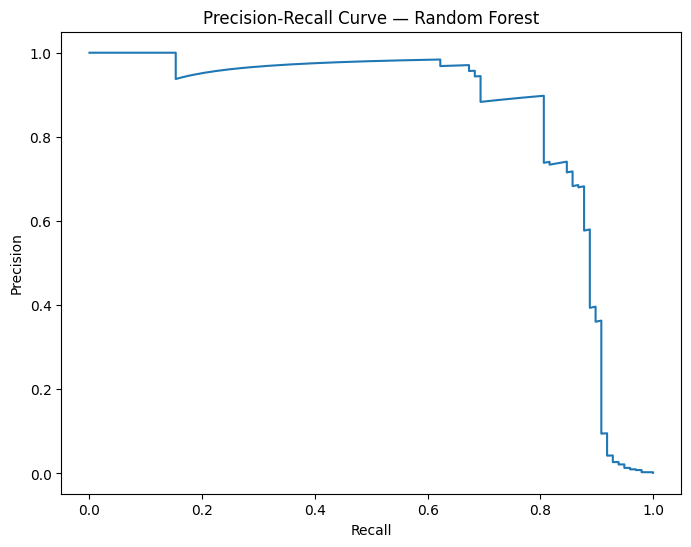

In [9]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — Random Forest")
plt.show()

# TEST CUSTOM THRESHOLDS

In [10]:
threshold_values = [0.2, 0.3, 0.4, 0.5, 0.6]

for t in threshold_values:
    y_pred = (y_probs >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_test, y_pred, digits=4))


Threshold = 0.2
              precision    recall  f1-score   support

           0     0.9998    0.9970    0.9984     56864
           1     0.3410    0.9082    0.4958        98

    accuracy                         0.9968     56962
   macro avg     0.6704    0.9526    0.7471     56962
weighted avg     0.9987    0.9968    0.9975     56962


Threshold = 0.3
              precision    recall  f1-score   support

           0     0.9998    0.9985    0.9991     56864
           1     0.4971    0.8878    0.6374        98

    accuracy                         0.9983     56962
   macro avg     0.7485    0.9431    0.8182     56962
weighted avg     0.9989    0.9983    0.9985     56962


Threshold = 0.4
              precision    recall  f1-score   support

           0     0.9998    0.9991    0.9994     56864
           1     0.6143    0.8776    0.7227        98

    accuracy                         0.9988     56962
   macro avg     0.8070    0.9383    0.8611     56962
weighted avg     0.9991

## Threshold Optimization Summary

By testing multiple thresholds on the Random Forest trained with SMOTE,
we observed a clear precision-recall trade-off.

A threshold of 0.4 was selected as it balances recall (~86%) and precision (~69%),
resulting in a strong F1-score (~0.76) and making the model suitable for
real-world fraud detection applications.

Lower thresholds would increase false positives, while higher thresholds
would miss more fraud cases. Threshold tuning ensures the model
aligns with business objectives and risk tolerance.
